In [1]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.optimizers import SGD,RMSprop
from keras.callbacks import *
from keras.utils import np_utils
from keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
import os,sys
import pickle
sys.path.append('/home/cs341seti/cs341-ibm-seti/')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import re
import collections
import sklearn
import scipy
import commonutils as cu
import model_specs
from sklearn import svm
from sklearn.externals import joblib

## Try path tracing algorithm

In [3]:
fileListDF = pd.read_csv('../data/fileList.csv',dtype={'file_index':str})
fileListDF.head()
fileListDF[fileListDF['signal_classification']=='squigglesquarepulsednarrowband'].head()

,file_name,signal_classification,uuid,file_index,label,dataset
0,00069203-0824-4136-9c99-b9f68672f23d.dat,squigglesquarepulsednarrowband,00069203-0824-4136-9c99-b9f68672f23d,000000,6,train
4,000c28b3-aeba-4f18-ac60-b91341921264.dat,squigglesquarepulsednarrowband,000c28b3-aeba-4f18-ac60-b91341921264,000004,6,train
7,00187356-1b8e-48e2-a2e9-b3983983d2f1.dat,squigglesquarepulsednarrowband,00187356-1b8e-48e2-a2e9-b3983983d2f1,000007,6,train
8,001d473c-be64-4411-8a3d-7f7160f94de4.dat,squigglesquarepulsednarrowband,001d473c-be64-4411-8a3d-7f7160f94de4,000008,6,train
10,002193db-6f0e-4e2a-a7a4-6fc038a1b2a7.dat,squigglesquarepulsednarrowband,002193db-6f0e-4e2a-a7a4-6fc038a1b2a7,000010,6,train


In [191]:
def pathTrace(spectrogram,alpha,relativeSearchWindow=0.2):
    
    # Initializations
    spectrogram = np.squeeze(spectrogram)
    (nrow,ncol) = spectrogram.shape[0:2]
    nSearchWindowSize = int(ncol*relativeSearchWindow) # speed up by not looking very far current point
    lossMat = np.zeros((nrow,ncol))
    pathMat = np.zeros((nrow,ncol))
    trace_vector = np.zeros((nrow,))
    intensity_vector = np.zeros((nrow,))
    
    # to save compute-time create a delta matrix (d_ij = (f_i-f_j)^2)
    freqs = np.array(range(ncol))
    deltaMat = np.square(freqs[:,np.newaxis]-freqs)
    
    # For each time instant
    for t in range(nrow):
        # Initialize current row loss
        lossMat[t,:] = -alpha*spectrogram[t,:]
        # if first row, skip the search for best previous point
        if t==0: continue
        # for each frequency for rows 1 (second row) - end
        for f_current in range(ncol):
            # find best previous point
            #searchRange = range(max(f_current-nSearchWindowSize//2,0),min(f_current+nSearchWindowSize//2,ncol-1))
            loss_increments = lossMat[t-1,:] + (1-alpha)*deltaMat[f_current,:]
            f_best_prev = np.argmin(loss_increments)
            best_loss_increment = loss_increments[f_best_prev]
#             best_loss_increment = sys.float_info.max
#             f_best_prev = 0
#             searchRange = (max(f_current-nSearchWindowSize//2,0),min(f_current+nSearchWindowSize//2,ncol-1))
#             for f_prev in range(searchRange[0],searchRange[1]):
#                 loss_increment = lossMat[t-1,f_prev] + (1-alpha)*(f_prev-f_current)**2;
#                 if loss_increment < best_loss_increment:
#                     f_best_prev = f_prev
#                     best_loss_increment = loss_increment
            # update loss for f_current
            lossMat[t,f_current] += best_loss_increment
            # update locally chosen path for f_current
            pathMat[t,f_current] = f_best_prev
    
    # Finding the best last point and tracing back
    minLoss = np.min(lossMat[nrow-1,:])
    trace_vector[nrow-1] = np.argmin(lossMat[nrow-1,:])
    intensity_vector[nrow-1] = spectrogram[nrow-1,int(trace_vector[nrow-1])]
    # tracing back from end-1 to 0
    for t in range(nrow-2,-1,-1):
        trace_vector[t] = pathMat[t+1,int(trace_vector[t+1])]
        intensity_vector[t] = spectrogram[t,int(trace_vector[t])]
    
    return [trace_vector,intensity_vector,minLoss]  

def generatePathTrace(alpha,dataset,file_index,base_path):
    x = img_to_array(load_img('{}{}.jpg'.format(base_path,file_index),grayscale=True))
    [trace,intensity,minLoss] = pathTrace(cu.modelutils.columnNormalize(x),alpha)
    return np.dstack([trace,intensity])

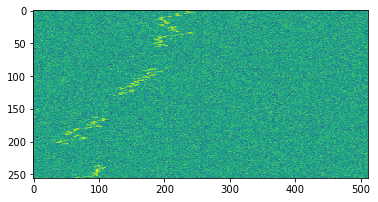

In [210]:
basepath = '../data/welch_specdataimages_gray_256x512_6/'
fid = '000010'
x = img_to_array(load_img('{}{}.jpg'.format(basepath,fid),grayscale=True))
plt.imshow((x[:,:,0]))
plt.show()

In [216]:
%time [trace,intensity,minLoss] = pathTrace(cu.modelutils.columnNormalize(x),0.5)
print(minLoss)

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.03 s
-5474.25


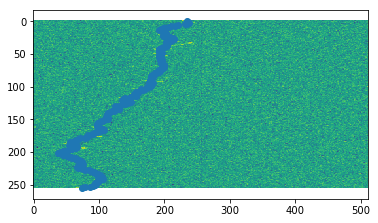

In [122]:
plt.imshow(x[:,:,0])
plt.scatter(trace,range(256))
plt.show()

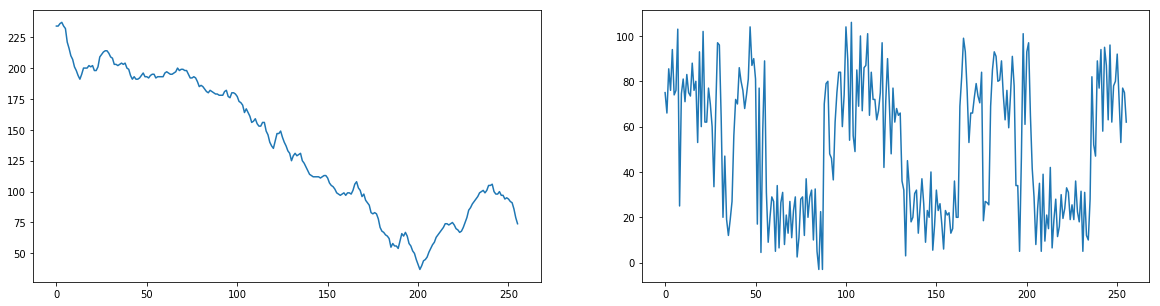

In [123]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(trace)
plt.subplot(122)
plt.plot(intensity)
plt.show()

In [167]:
np.dstack([trace,intensity]).shape

(1, 256, 2)

# Generate traces for all images

# Generate dataset with traces

In [ ]:
alpha = 0.5
sourcePath = '../data/welch_specdataimages_gray_256x512_6/'
fileListPath = '../data/fileList.csv'
destfname = '../data/traceDataset_0.5alpha.hdf5'
loader = cu.traceutils.pathTraceLoader(alpha,(256,2))
cu.datautils.createDataset(sourcePath=sourcePath,fileListPath=fileListPath,destFilename=destfname,
                           loadImages=False,loaderFn=loader.loaderFn,datShape=loader.shape)

# Experimenting with some traces 

In [ ]:
%%time
alpha = 0.2
imsize = (256,512)
loader = cu.traceutils.pathTraceLoader(alpha,(256,2))
basepath = '../data/welch_specdataimages_gray_256x512_6/'
# n x t x 2 array containing 2 time-series: trace, intensity for all signals
n = 1000
traceDataset = np.zeros((n,imsize[0],2))
for i in range(n):
    print('\r{}'.format(i)),
    traceDataset[i] = loader.loaderFn('{}{}.jpg'.format(basepath,fileListDF['file_index'].ix[i]))
np.save('traceData_subset_0.2alpha.npy',traceDataset)

In [93]:
traceDataset = np.load('traceData_subset_0.2alpha.npy')

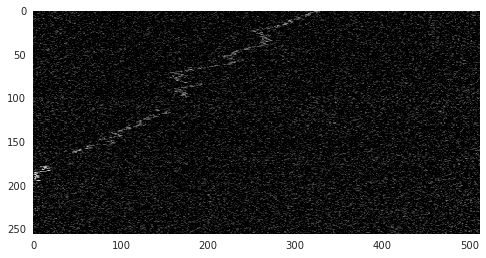

In [94]:
basepath = '../data/welch_specdataimages_gray_256x512_6/'
fid = '000007'
nid = int(fid)
x = img_to_array(load_img('{}{}.jpg'.format(basepath,fid),grayscale=True))
x = cu.modelutils.columnNormalize(x)
x = x.clip(min=0)
fig, ax = plt.subplots(1, 1)
ax.grid(False)
plt.set_cmap('gray')
ax.imshow((x[:,:,0]))
plt.show()

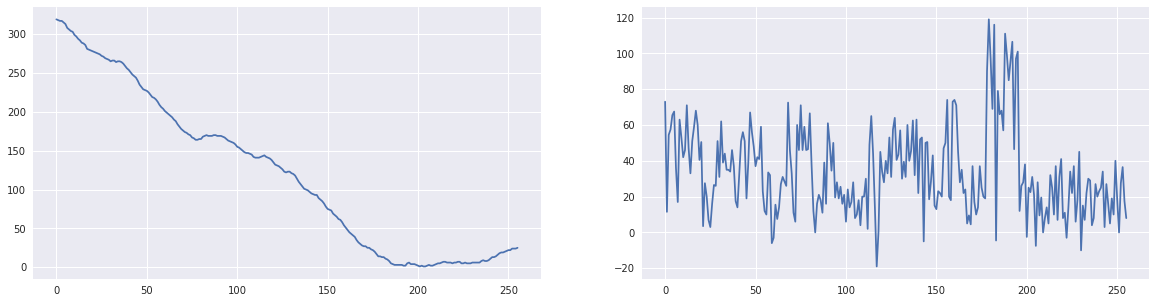

In [95]:
x_test = traceDataset[nid]
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(traceDataset[nid,:,0])
plt.subplot(122)
plt.plot(traceDataset[nid,:,1])
plt.show()

In [6]:
traceDataset.shape

(1000, 256, 2)

# Generating features from traces

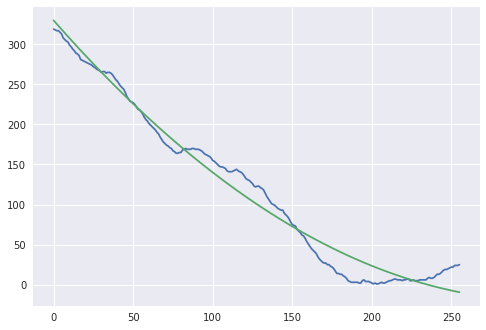

In [9]:
fit = np.polyfit(range(256),x_test[:,0],2,full=True)
f = np.poly1d(np.polyfit(range(256),x_test[:,0],2))
plt.plot(range(256),x_test[:,0])
plt.plot(range(256),f(range(256)))
plt.show()

In [10]:
# calculate poly
def generatePolynomialFeatures(traceDataset,order=2):
    features = np.zeros((traceDataset.shape[0],order+1))
    for i in range(traceDataset.shape[0]):
        x = traceDataset[i]
        fit = np.polyfit(range(x.shape[0]),x[:,0],order)
        features[i,:] = fit
    return features

def generateDistributionFeatures(traceDataset):
    ncols = traceDataset.shape[2]
    features = np.zeros((traceDataset.shape[0],ncols*2))
    for i in range(traceDataset.shape[0]):
        x = traceDataset[i]
        # Total signal variation: standard deviation of differences
        # running a small moving average so that stuff doesn't get too noisy
        features[i,0:ncols] = np.apply_along_axis(
            lambda x: np.std(np.convolve(np.diff(x),np.ones((3,))/3)),0,x)
        features[i,ncols:] = scipy.stats.kurtosis(x,axis=0)
    return features

In [14]:
polyFeatures = generatePolynomialFeatures(traceDataset)
distFeatures = generateDistributionFeatures(traceDataset)
featuresDF = pd.DataFrame(np.concatenate([polyFeatures,distFeatures],axis=1))
#featuresDF.columns = ['a','b','c']
featuresDF['label'] = fileListDF['label'].ix[0:1000]
featuresDF['label'] = featuresDF['label'].apply(str)

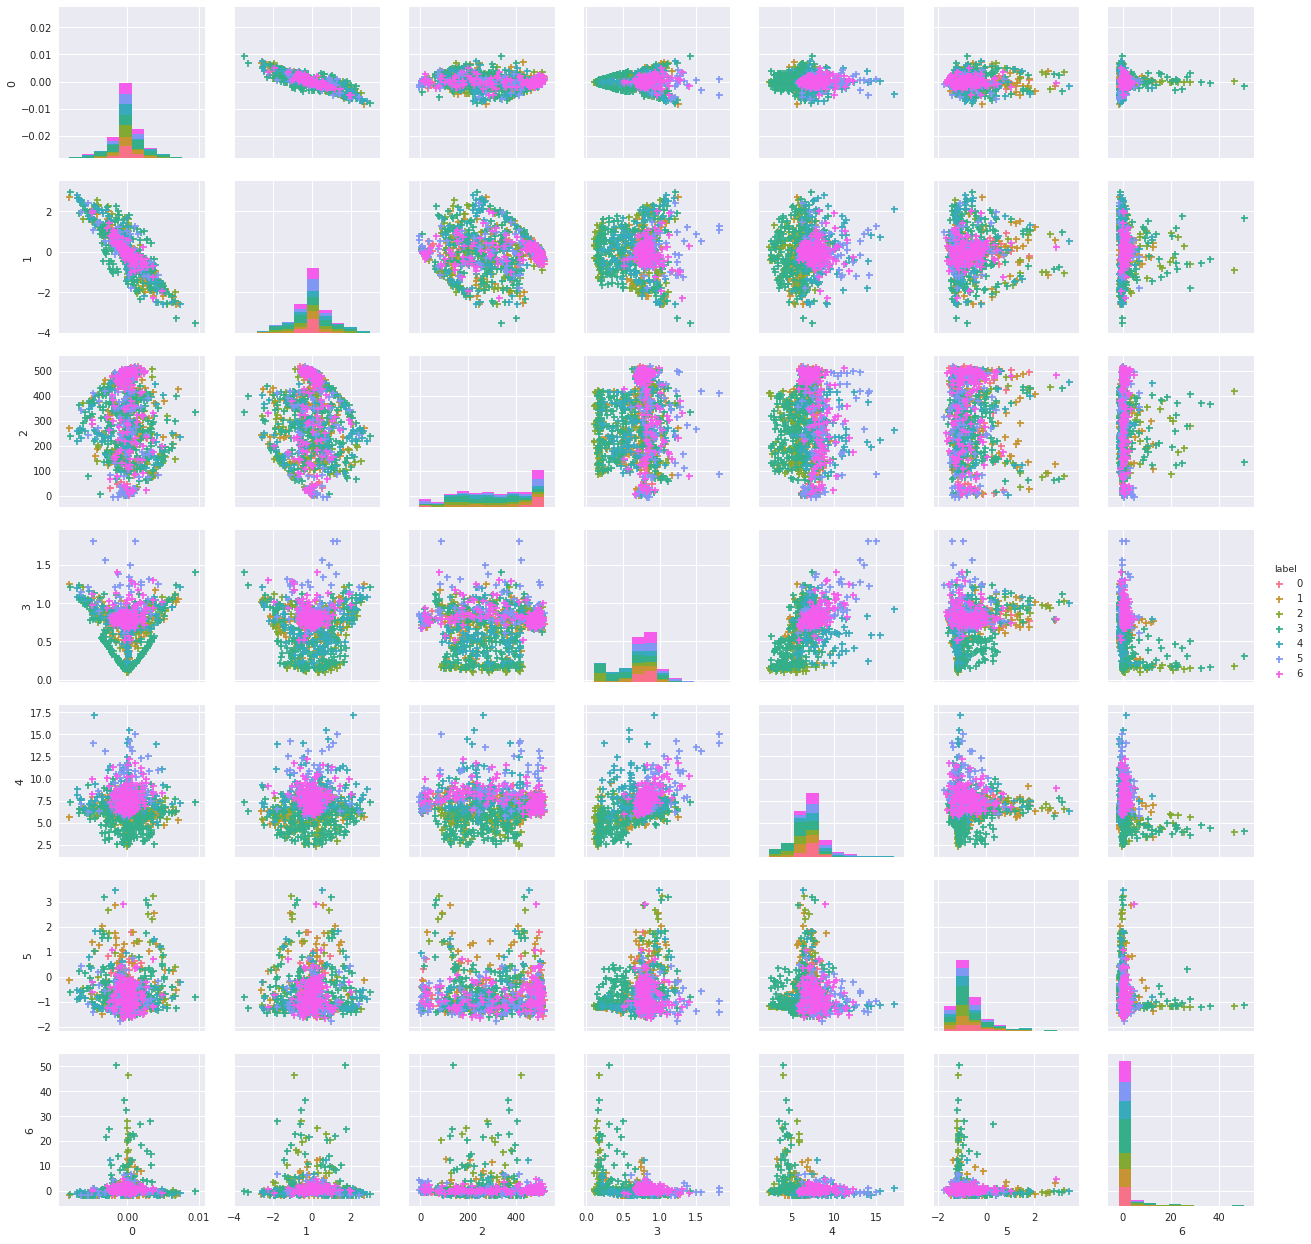

In [25]:
featureCols = featuresDF.columns[0:len(featuresDF.columns)-1]
sns.pairplot(featuresDF,vars=featureCols,hue='label',markers='+')
plt.show()

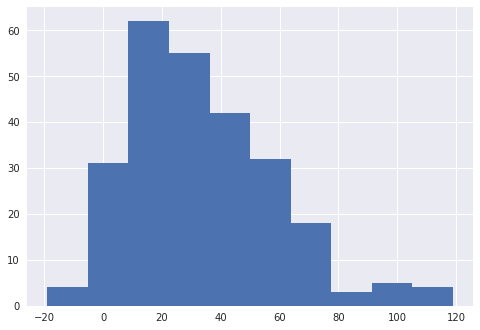

In [119]:
# total variation and entropy of signals 
plt.hist(x_test[:,1],bins=10)
plt.show()

In [79]:
scipy.stats.entropy(np.histogram(x_test[:,0],bins=10,density=True)[0])

2.0341737290118709

In [116]:
scipy.stats.kurtosis(x_test,axis=0)

array([-1.19812171,  0.8483274 ])

In [140]:
np.apply_along_axis(lambda x: np.std(np.convolve(np.diff(x),np.ones((3,))/3)),0,x_test)

array([ 1.30267249,  9.17247294])

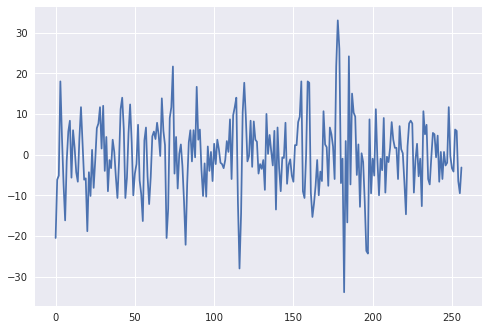

In [113]:
plt.plot(np.convolve(np.diff(x_test[:,1]),np.ones((3,))/3))
plt.show()

# Classifiying from trace features

## Noise v rest

In [89]:
# Trying out a linear SVM
indices = featuresDF['label'].apply(lambda x: x in ['0','2','3','4','5','6']) 
x_train = featuresDF[featureCols].ix[indices]
# Scaling training and test data
means = np.mean(x_train,axis=0)
stddev = np.std(x_train,axis=0)
# Preventing zero division
x_train = (x_train - means)/(stddev+1e-3)

y_train = featuresDF['label'].ix[indices].apply(int)
y_train[y_train!=0] = 1
nDataset = x_train.shape[0]

C_values = 10**np.random.uniform(0,4,20)
train_scores = []

for C_val in C_values:
    lin_clf = svm.LinearSVC(C=C_val/nDataset,verbose=True,class_weight='balanced')
    #lin_clf = svm.SVC(C=C_val/nDataset,gamma='auto',verbose=True,class_weight='balanced',
                          #decision_function_shape='ovr')
    lin_clf.fit(x_train, y_train)
    pred_train = lin_clf.predict(x_train)
    train_score = sklearn.metrics.accuracy_score(y_train,pred_train)
    train_scores.append(train_score)
    print("Results for C={}:".format(C_val))
    print("Train score={}".format(train_score))

[LibLinear]Results for C=6.7702449225:
Train score=0.580571428571
[LibLinear]Results for C=2.48467478502:
Train score=0.576
[LibLinear]Results for C=239.596503868:
Train score=0.586285714286
[LibLinear]Results for C=4.21107853861:
Train score=0.579428571429
[LibLinear]Results for C=9448.61104343:
Train score=0.6
[LibLinear]Results for C=4.69521825945:
Train score=0.580571428571
[LibLinear]Results for C=2647.01910608:
Train score=0.586285714286
[LibLinear]Results for C=41.197402354:
Train score=0.582857142857
[LibLinear]Results for C=3216.51272413:
Train score=0.585142857143
[LibLinear]Results for C=28.0590454493:
Train score=0.584
[LibLinear]Results for C=5643.43927737:
Train score=0.586285714286
[LibLinear]Results for C=1.53774460289:
Train score=0.570285714286
[LibLinear]Results for C=8543.37119304:
Train score=0.585142857143
[LibLinear]Results for C=189.649812421:
Train score=0.586285714286
[LibLinear]Results for C=4.72211596798:
Train score=0.580571428571
[LibLinear]Results for C=1

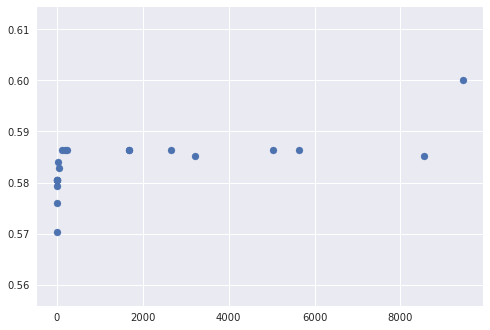

In [90]:
plt.scatter(C_values,train_scores)
plt.show()

In [82]:
C_val = 8615.68839132
#lin_clf = svm.LinearSVC(C=C_val/nDataset,verbose=True,class_weight='balanced')
lin_clf = svm.SVC(C=C_val/nDataset,gamma='auto',verbose=True,class_weight='balanced',
                          decision_function_shape='ovr')
lin_clf.fit(x_train, y_train)
pred_train = lin_clf.predict(x_train)
train_score = sklearn.metrics.accuracy_score(y_train,pred_train)

print(sklearn.metrics.classification_report(y_train,pred_train) )
print(sklearn.metrics.confusion_matrix(y_train,pred_train) )
print("Train Classification accuracy: %0.2f" % sklearn.metrics.accuracy_score(y_train,pred_train) )

[LibSVM]             precision    recall  f1-score   support

          0       0.34      1.00      0.51       123
          1       1.00      0.68      0.81       752

avg / total       0.91      0.73      0.77       875

[[123   0]
 [238 514]]
Train Classification accuracy: 0.73


## Signal classes

In [97]:
# Trying out a linear SVM
indices = featuresDF['label'].apply(lambda x: x in ['2','3','4','5','6']) 
x_train = featuresDF[featureCols].ix[indices]
# Scaling training and test data
means = np.mean(x_train,axis=0)
stddev = np.std(x_train,axis=0)
# Preventing zero division
x_train = (x_train - means)/(stddev+1e-3)

y_train = featuresDF['label'].ix[indices].apply(int)
nDataset = x_train.shape[0]

C_values = 10**np.random.uniform(0,5,20)
train_scores = []

for C_val in C_values:
    lin_clf = svm.LinearSVC(C=C_val/nDataset,verbose=True,class_weight='balanced')
    #lin_clf = svm.SVC(C=C_val/nDataset,gamma='auto',verbose=True,class_weight='balanced',
                         # decision_function_shape='ovr')
    lin_clf.fit(x_train, y_train)
    pred_train = lin_clf.predict(x_train)
    train_score = sklearn.metrics.accuracy_score(y_train,pred_train)
    train_scores.append(train_score)
    print("Results for C={}:".format(C_val))
    print("Train score={}".format(train_score))

[LibLinear]Results for C=331.23632663:
Train score=0.480053191489
[LibLinear]Results for C=102.97463473:
Train score=0.481382978723
[LibLinear]Results for C=1.06503641473:
Train score=0.466755319149
[LibLinear]Results for C=19491.173766:
Train score=0.456117021277
[LibLinear]Results for C=23288.2385175:
Train score=0.469414893617
[LibLinear]Results for C=7937.12734022:
Train score=0.474734042553
[LibLinear]Results for C=927.097165475:
Train score=0.482712765957
[LibLinear]Results for C=1692.48956496:
Train score=0.484042553191
[LibLinear]Results for C=16.5071667848:
Train score=0.478723404255
[LibLinear]Results for C=11.4422609612:
Train score=0.476063829787
[LibLinear]Results for C=7354.94895942:
Train score=0.472074468085
[LibLinear]Results for C=23025.857098:
Train score=0.442819148936
[LibLinear]Results for C=13.9487889959:
Train score=0.477393617021
[LibLinear]Results for C=162.850247439:
Train score=0.481382978723
[LibLinear]Results for C=275.695337633:
Train score=0.478723404255

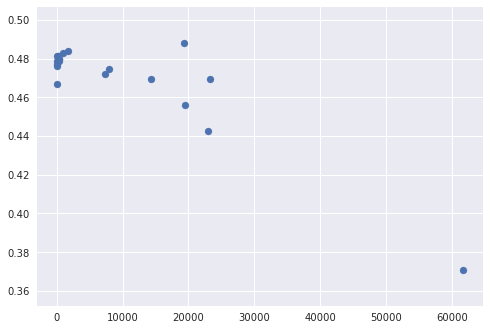

In [98]:
plt.scatter(C_values,train_scores)
plt.show()

In [87]:
C_val = 92349.5981156
#lin_clf = svm.LinearSVC(C=C_val/nDataset,verbose=True,class_weight='balanced')
lin_clf = svm.SVC(C=C_val/nDataset,gamma='auto',verbose=True,class_weight='balanced',
                          decision_function_shape='ovr')
lin_clf.fit(x_train, y_train)
pred_train = lin_clf.predict(x_train)
train_score = sklearn.metrics.accuracy_score(y_train,pred_train)

print(sklearn.metrics.classification_report(y_train,pred_train) )
print(sklearn.metrics.confusion_matrix(y_train,pred_train) )
print("Train Classification accuracy: %0.2f" % sklearn.metrics.accuracy_score(y_train,pred_train) )

[LibSVM]             precision    recall  f1-score   support

          2       0.76      0.84      0.80       122
          3       0.97      0.71      0.82       251
          4       0.86      0.85      0.85       118
          5       0.71      0.75      0.73       125
          6       0.64      0.87      0.74       136

avg / total       0.82      0.79      0.79       752

[[103   4   5   1   9]
 [ 30 178   8  17  18]
 [  1   0 100   5  12]
 [  1   0   2  94  28]
 [  0   1   1  16 118]]
Train Classification accuracy: 0.79


In [ ]:
subsetClasses = {0.0:0.0,2.0:1.0,3.0:2.0,4.0:3.0,5.0:4.0,6.0:5.0}
traceDataset_01_alpha = cu.datautils.loadDataset('../data/traceDataset_0.1alpha.hdf5',subsetClasses=subsetClasses)